# Подготовка классификатора, разметка исходных данных классификатором.

В этом блокноте приведены этапы работы с классификатором: обучение, подсчет метрик качества обученного классификатора, получение вторичной разметки классификатором на основе первичной разметки от OWLv2.

## Обучение

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import os
import copy
import time

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(10),           # Случайный поворот на ±10 градусов
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Изменение цветов
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
def create_data_loaders(data_dir, batch_size=32):
    """
    Создает DataLoader'ы для уже подготовленных изображений 224x224
    """
    image_datasets = {
        x: datasets.ImageFolder(
            os.path.join(data_dir, x),
            data_transforms[x]
        )
        for x in ['train', 'val']
    }

    dataloaders = {
        x: torch.utils.data.DataLoader(
            image_datasets[x],
            batch_size=batch_size,
            shuffle=True if x == 'train' else False,
            num_workers=4,
            pin_memory=True  # Ускоряет передачу данных на GPU
        )
        for x in ['train', 'val']
    }

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes

    return dataloaders, dataset_sizes, class_names

In [ ]:
def setup_model(num_classes, unfreeze_layers=True):
    """
    Настраивает модель ResNet
    """
    # Загружаем предобученную ResNet18
    model = models.resnet18(weights='IMAGENET1K_V1')

    # Заменяем последний слой
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    if unfreeze_layers:
        # Размораживаем последние слои для дообучения
        for name, param in model.named_parameters():
            if 'layer4' in name or 'fc' in name:  # Последний слой и полносвязный
                param.requires_grad = True
            else:
                param.requires_grad = False
    else:
        # Замораживаем все слои кроме последнего
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True

    return model

In [ ]:
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    """
    Функция обучения модели
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        start_time = time.time()

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Сохраняем историю
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        epoch_time = time.time() - start_time
        print(f'Epoch time: {epoch_time:.2f}s\n')

    print(f'Best val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
def main():
    # Настройки
    data_dir = '/content/drive/MyDrive/TBankSirius/data_for_classification'  # Папка с данными
    batch_size = 64    # Можно увеличить batch_size, так как изображения уже маленькие
    num_epochs = 15

    # Проверяем доступность GPU
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Создаем DataLoader'ы
    dataloaders, dataset_sizes, class_names = create_data_loaders(data_dir, batch_size)
    print(f"Classes: {class_names}")
    print(f"Dataset sizes: {dataset_sizes}")

    # Настраиваем модель
    model = setup_model(len(class_names), unfreeze_layers=True)

    # Функция потерь и оптимизатор
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=0.001,
        weight_decay=1e-4
    )

    # Планировщик обучения
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Обучаем модель
    print("Starting training...")
    model_trained, history = train_model(
        model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs
    )

    # Сохраняем модель
    torch.save({
        'model_state_dict': model_trained.state_dict(),
        'class_names': class_names,
        'history': history
    }, 'resnet18_finetuned_224.pth')

    print("Training completed! Model saved.")

if __name__ == "__main__":
    main()

Using device: cuda:0


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Classes: ['1_TBank_only_logo_224', '2_Rosneft_224', '3_Raiffazen_224', '4_Other_224', '5_Tinkoff_224', '6_OnlyT_224']
Dataset sizes: {'train': 650, 'val': 82}
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s]


Starting training...
Epoch 0/14
----------
train Loss: 0.4023 Acc: 0.8615
val Loss: 0.4850 Acc: 0.9024
Epoch time: 109.20s

Epoch 1/14
----------
train Loss: 0.0672 Acc: 0.9800
val Loss: 0.5016 Acc: 0.9268
Epoch time: 5.58s

Epoch 2/14
----------
train Loss: 0.0339 Acc: 0.9892
val Loss: 0.2421 Acc: 0.9390
Epoch time: 5.28s

Epoch 3/14
----------
train Loss: 0.0691 Acc: 0.9846
val Loss: 0.2070 Acc: 0.9634
Epoch time: 4.59s

Epoch 4/14
----------
train Loss: 0.0283 Acc: 0.9938
val Loss: 0.3474 Acc: 0.9390
Epoch time: 6.68s

Epoch 5/14
----------
train Loss: 0.0258 Acc: 0.9938
val Loss: 0.5122 Acc: 0.9268
Epoch time: 5.54s

Epoch 6/14
----------
train Loss: 0.1110 Acc: 0.9615
val Loss: 0.5069 Acc: 0.9268
Epoch time: 4.86s

Epoch 7/14
----------
train Loss: 0.0674 Acc: 0.9723
val Loss: 0.3270 Acc: 0.9390
Epoch time: 6.05s

Epoch 8/14
----------
train Loss: 0.0278 Acc: 0.9908
val Loss: 0.2403 Acc: 0.9634
Epoch time: 4.67s

Epoch 9/14
----------
train Loss: 0.0200 Acc: 0.9938
val Loss: 0.233

In [ ]:
def predict_image(image_path, model, class_names, device='cuda'):
    """
    Предсказание для одного изображения 224x224
    """
    # Упрощенные преобразования для предсказания
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert('RGB')

    # Проверяем размер изображения
    if image.size != (224, 224):
        print(f"Warning: Image size is {image.size}, expected (224, 224)")
        image = image.resize((224, 224))

    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        conf, preds = torch.max(probs, 1)

    return class_names[preds.item()], conf.item()

def load_trained_model(model_path, device='cuda'):
    """
    Загрузка обученной модели
    """
    checkpoint = torch.load(model_path, map_location=device)

    # Создаем модель
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, len(checkpoint['class_names']))
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()

    return model, checkpoint['class_names'], checkpoint.get('history', {})

## Подсчет метрик

Загрузка модели и данных...
Using device: cuda
Вычисление метрик...

ОСНОВНЫЕ МЕТРИКИ
Accuracy: 0.9737
Precision (macro): 0.9667
Recall (macro): 0.9167
F1-Score (macro): 0.9259
Precision (weighted): 0.9789
Recall (weighted): 0.9737
F1-Score (weighted): 0.9708

МЕТРИКИ ПО КЛАССАМ
1_TBank_only_logo_224 | Precision: 0.800 | Recall: 1.000 | F1: 0.889 | Support: 4.0
2_Rosneft_224        | Precision: 1.000 | Recall: 1.000 | F1: 1.000 | Support: 8.0
3_Raiffazen_224      | Precision: 1.000 | Recall: 1.000 | F1: 1.000 | Support: 8.0
4_Other_224          | Precision: 1.000 | Recall: 1.000 | F1: 1.000 | Support: 8.0
5_Tinkoff_224        | Precision: 1.000 | Recall: 1.000 | F1: 1.000 | Support: 8.0
6_OnlyT_224          | Precision: 1.000 | Recall: 0.500 | F1: 0.667 | Support: 2.0

Создание визуализаций...


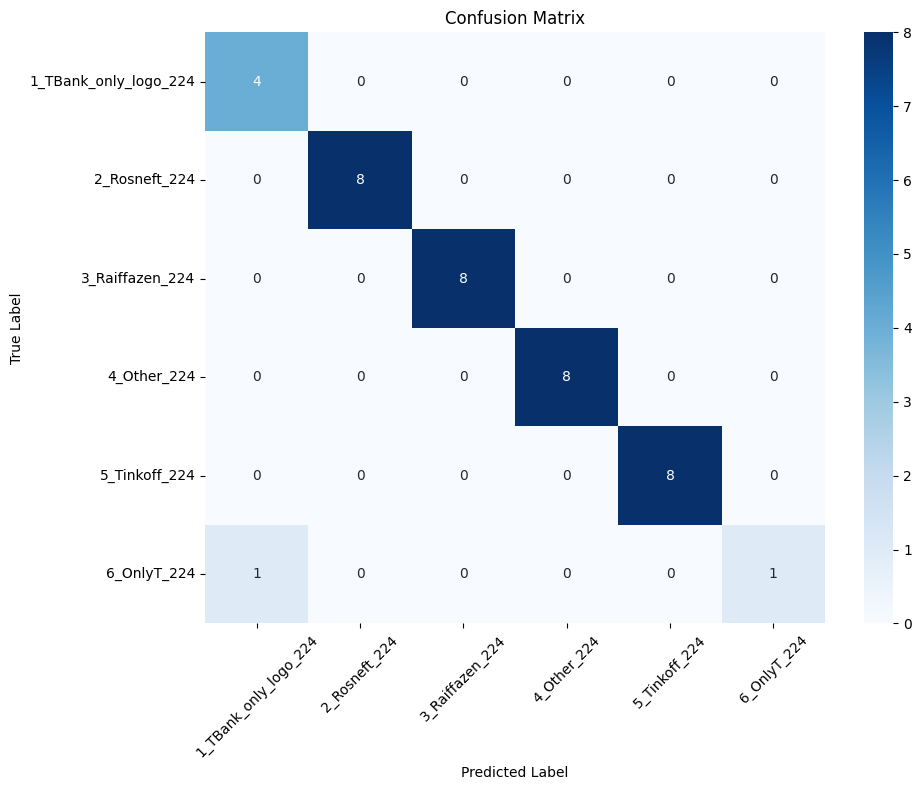

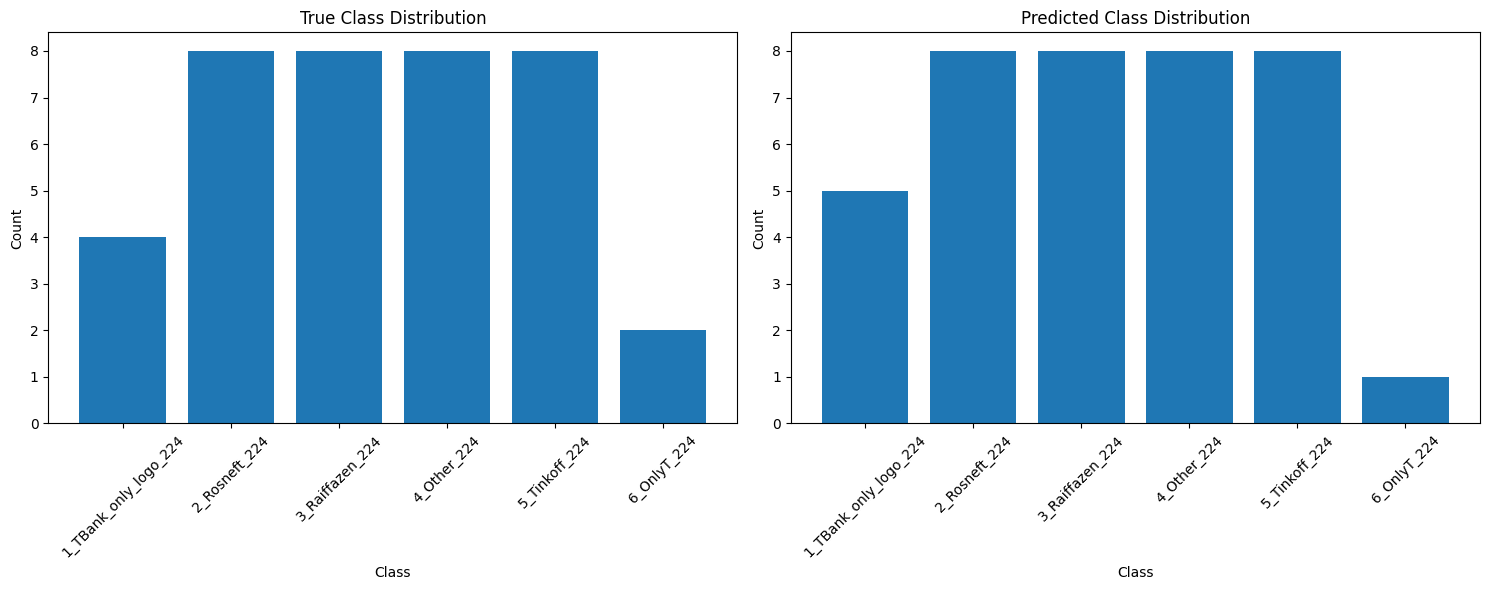

Метрики сохранены в: metrics_results/metrics_report.json

Все результаты сохранены в папке: metrics_results


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
import os
import json
from datetime import datetime

class MetricCalculator:
    def __init__(self, model, dataloader, class_names, device='cuda'):
        self.model = model
        self.dataloader = dataloader
        self.class_names = class_names
        self.device = device
        self.model.eval()

        self.true_labels = []
        self.pred_labels = []
        self.pred_probs = []

    def calculate_metrics(self):
        """Вычисляет все метрики"""
        print("Вычисление метрик...")

        # Собираем предсказания
        self._collect_predictions()

        # Вычисляем метрики
        metrics = {
            'overall_accuracy': accuracy_score(self.true_labels, self.pred_labels),
            'precision_macro': precision_score(self.true_labels, self.pred_labels, average='macro', zero_division=0),
            'recall_macro': recall_score(self.true_labels, self.pred_labels, average='macro', zero_division=0),
            'f1_macro': f1_score(self.true_labels, self.pred_labels, average='macro', zero_division=0),
            'precision_weighted': precision_score(self.true_labels, self.pred_labels, average='weighted', zero_division=0),
            'recall_weighted': recall_score(self.true_labels, self.pred_labels, average='weighted', zero_division=0),
            'f1_weighted': f1_score(self.true_labels, self.pred_labels, average='weighted', zero_division=0),
        }

        # Детальный отчет по классам
        class_report = classification_report(
            self.true_labels, self.pred_labels,
            target_names=self.class_names, output_dict=True, zero_division=0
        )

        # Матрица ошибок
        cm = confusion_matrix(self.true_labels, self.pred_labels)

        return metrics, class_report, cm

    def _collect_predictions(self):
        """Собирает предсказания модели"""
        self.true_labels = []
        self.pred_labels = []
        self.pred_probs = []

        with torch.no_grad():
            for inputs, labels in self.dataloader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(inputs)
                probs = torch.nn.functional.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, 1)

                self.true_labels.extend(labels.cpu().numpy())
                self.pred_labels.extend(preds.cpu().numpy())
                self.pred_probs.extend(probs.cpu().numpy())

        self.true_labels = np.array(self.true_labels)
        self.pred_labels = np.array(self.pred_labels)
        self.pred_probs = np.array(self.pred_probs)

    def plot_confusion_matrix(self, cm, save_path=None):
        """Визуализация матрицы ошибок"""
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.class_names,
                   yticklabels=self.class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

    def plot_class_distribution(self, save_path=None):
        """Визуализация распределения классов"""
        true_counts = np.bincount(self.true_labels)
        pred_counts = np.bincount(self.pred_labels, minlength=len(self.class_names))

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Истинное распределение
        ax1.bar(range(len(self.class_names)), true_counts)
        ax1.set_title('True Class Distribution')
        ax1.set_xlabel('Class')
        ax1.set_ylabel('Count')
        ax1.set_xticks(range(len(self.class_names)))
        ax1.set_xticklabels(self.class_names, rotation=45)

        # Предсказанное распределение
        ax2.bar(range(len(self.class_names)), pred_counts)
        ax2.set_title('Predicted Class Distribution')
        ax2.set_xlabel('Class')
        ax2.set_ylabel('Count')
        ax2.set_xticks(range(len(self.class_names)))
        ax2.set_xticklabels(self.class_names, rotation=45)

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

    def save_metrics_to_json(self, metrics, class_report, save_path):
        """Сохраняет метрики в JSON файл"""
        report_data = {
            'timestamp': datetime.now().isoformat(),
            'overall_metrics': metrics,
            'per_class_metrics': class_report,
            'class_names': self.class_names,
            'dataset_size': len(self.true_labels)
        }

        with open(save_path, 'w', encoding='utf-8') as f:
            json.dump(report_data, f, indent=2, ensure_ascii=False)

        print(f"Метрики сохранены в: {save_path}")

def load_model_and_data(model_path, data_dir, batch_size=32):
    """Загружает модель и данные"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Загрузка модели
    checkpoint = torch.load(model_path, map_location=device)

    model = models.resnet18(weights=None)
    num_classes = len(checkpoint['class_names'])
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)

    # Преобразования для данных
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Загрузка данных
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return model, dataloader, checkpoint['class_names'], device

def calculate_detailed_metrics(true_labels, pred_labels, pred_probs, class_names):
    """Вычисляет дополнительные метрики"""
    from sklearn.metrics import roc_auc_score, roc_curve, auc

    metrics = {}

    # ROC AUC для каждого класса (если бинарная или мультиклассовая)
    if len(class_names) == 2:
        # Бинарная классификация
        fpr, tpr, _ = roc_curve(true_labels, pred_probs[:, 1])
        roc_auc = auc(fpr, tpr)
        metrics['roc_auc'] = roc_auc
    else:
        # Мультиклассовая классификация
        try:
            roc_auc = roc_auc_score(true_labels, pred_probs, multi_class='ovr')
            metrics['roc_auc_macro'] = roc_auc
        except:
            metrics['roc_auc_macro'] = 'Not available'

    return metrics

def main():
    # Конфигурация
    MODEL_PATH = '/content/resnet18_finetuned_224.pth'  # Путь к вашей модели
    DATA_DIR = '/content/drive/MyDrive/TBankSirius/data_for_classification/test'                      # Путь к данным для тестирования
    OUTPUT_DIR = 'metrics_results'             # Папка для сохранения результатов

    # Создаем папку для результатов
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Загружаем модель и данные
    print("Загрузка модели и данных...")
    model, dataloader, class_names, device = load_model_and_data(MODEL_PATH, DATA_DIR)

    # Вычисляем метрики
    calculator = MetricCalculator(model, dataloader, class_names, device)
    metrics, class_report, cm = calculator.calculate_metrics()

    # Выводим основные метрики
    print("\n" + "="*50)
    print("ОСНОВНЫЕ МЕТРИКИ")
    print("="*50)
    print(f"Accuracy: {metrics['overall_accuracy']:.4f}")
    print(f"Precision (macro): {metrics['precision_macro']:.4f}")
    print(f"Recall (macro): {metrics['recall_macro']:.4f}")
    print(f"F1-Score (macro): {metrics['f1_macro']:.4f}")
    print(f"Precision (weighted): {metrics['precision_weighted']:.4f}")
    print(f"Recall (weighted): {metrics['recall_weighted']:.4f}")
    print(f"F1-Score (weighted): {metrics['f1_weighted']:.4f}")

    # Выводим метрики по классам
    print("\n" + "="*50)
    print("МЕТРИКИ ПО КЛАССАМ")
    print("="*50)
    for class_name in class_names:
        if class_name in class_report:  # Пропускаем 'macro avg', 'weighted avg'
            stats = class_report[class_name]
            print(f"{class_name:20s} | Precision: {stats['precision']:.3f} | "
                  f"Recall: {stats['recall']:.3f} | F1: {stats['f1-score']:.3f} | "
                  f"Support: {stats['support']}")

    # Визуализации
    print("\nСоздание визуализаций...")
    calculator.plot_confusion_matrix(cm, save_path=os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
    calculator.plot_class_distribution(save_path=os.path.join(OUTPUT_DIR, 'class_distribution.png'))

    # Сохраняем метрики в файл
    calculator.save_metrics_to_json(
        metrics, class_report,
        os.path.join(OUTPUT_DIR, 'metrics_report.json')
    )

    # Сохраняем детальный отчет в CSV
    df_report = pd.DataFrame(class_report).T
    df_report.to_csv(os.path.join(OUTPUT_DIR, 'detailed_metrics.csv'))

    print(f"\nВсе результаты сохранены в папке: {OUTPUT_DIR}")

if __name__ == "__main__":
    main()

### Предикт для 1 картинки

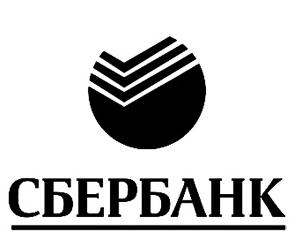

In [ ]:
from PIL import Image
image = Image.open('/content/0c85f7bde083f03e72c1eb2428faaa76.jpg')
image

In [ ]:
def load_trained_model(model_path, device='cuda'):
    """
    Загрузка обученной модели
    """
    checkpoint = torch.load(model_path, map_location=device)

    # Создаем модель
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, len(checkpoint['class_names']))
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()

    return model, checkpoint['class_names'], checkpoint.get('history', {})

def predict_image(image_path, model, class_names, device='cuda'):
    """
    Предсказание для одного изображения 224x224
    """
    # Упрощенные преобразования для предсказания
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert('RGB')

    # Проверяем размер изображения
    if image.size != (224, 224):
        print(f"Warning: Image size is {image.size}, expected (224, 224)")
        image = image.resize((224, 224))

    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        conf, preds = torch.max(probs, 1)

    return class_names[preds.item()], conf.item()

In [ ]:
def predict_single_image(model_path, image_path, device='cuda'):
    """
    Упрощенная функция для предсказания без аргументов командной строки
    """
    # Проверяем доступность GPU
    if device == 'cuda' and not torch.cuda.is_available():
        device = 'cpu'
        print("Используется CPU")

    # Загружаем модель
    model, class_names, _ = load_trained_model(model_path, device)

    # Делаем предсказание
    predicted_class, confidence = predict_image(image_path, model, class_names, device)

    return predicted_class, confidence, class_names


In [ ]:
MODEL_PATH = "/content/drive/MyDrive/TBankSirius/resnet18_finetuned_224.pth"  # Укажите ваш путь к модели
IMAGE_PATH = "/content/0c85f7bde083f03e72c1eb2428faaa76.jpg"              # Укажите путь к test изображению

if os.path.exists(MODEL_PATH) and os.path.exists(IMAGE_PATH):
    print("Запуск предсказания...")
    predicted_class, confidence, class_names = predict_single_image(MODEL_PATH, IMAGE_PATH)

    print(f"\nРезультат:")
    print(f"Класс: {predicted_class}")
    print(f"Уверенность: {confidence:.4f}")
    print(f"Доступные классы: {class_names}")
else:
    print("Проверьте пути к файлам модели и изображения!")

Запуск предсказания...
Используется CPU

Результат:
Класс: 4_Other_224
Уверенность: 0.9993
Доступные классы: ['1_TBank_only_logo_224', '2_Rosneft_224', '3_Raiffazen_224', '4_Other_224', '5_Tinkoff_224', '6_OnlyT_224']


## Создание вторичной разметки классификатором на исходных данных

In [ ]:
'''
yolo_dataset/          # Корневая папка проекта
├── datasets.yaml      # Главный конфигурационный файл (указывает на все пути)
├── images/            # ВСЕ изображения лежат здесь
│   ├── train/         # Изображения для обучения
│   │   ├── img_001.jpg
│   │   ├── img_002.jpg
│   │   └── ...        # (~70% от всех данных)
│   ├── val/           # Изображения для валидации
│   │   ├── img_101.jpg
│   │   ├── img_102.jpg
│   │   └── ...        # (~15% от всех данных)
│   └── test/          # Изображения для финального тестирования
│       ├── img_201.jpg
│       ├── img_202.jpg
│       └── ...        # (~15% от всех данных)
└── labels/            # ВСЕ разметки лежат здесь (имена файлов = именам изображений)
    ├── train/
    │   ├── img_001.txt
    │   ├── img_002.txt
    │   └── ...
    ├── val/
    │   ├── img_101.txt
    │   ├── img_102.txt
    │   └── ...
    └── test/
        ├── img_201.txt
        ├── img_202.txt
        └── ...
'''

'\nyolo_dataset/          # Корневая папка проекта\n├── datasets.yaml      # Главный конфигурационный файл (указывает на все пути)\n├── images/            # ВСЕ изображения лежат здесь\n│   ├── train/         # Изображения для обучения\n│   │   ├── img_001.jpg\n│   │   ├── img_002.jpg\n│   │   └── ...        # (~70% от всех данных)\n│   ├── val/           # Изображения для валидации\n│   │   ├── img_101.jpg\n│   │   ├── img_102.jpg\n│   │   └── ...        # (~15% от всех данных)\n│   └── test/          # Изображения для финального тестирования\n│       ├── img_201.jpg\n│       ├── img_202.jpg\n│       └── ...        # (~15% от всех данных)\n└── labels/            # ВСЕ разметки лежат здесь (имена файлов = именам изображений)\n    ├── train/\n    │   ├── img_001.txt\n    │   ├── img_002.txt\n    │   └── ...\n    ├── val/\n    │   ├── img_101.txt\n    │   ├── img_102.txt\n    │   └── ...\n    └── test/\n        ├── img_201.txt\n        ├── img_202.txt\n        └── ...\n'

Ситуции:
1. 0 файлов в crops_datasirius/имя_картинки/crops -> нет детекций
2. n файлов в crops_datasirius/имя_картинки/crops (n!=0) -> детекций n/3

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import os
import copy
import time

In [ ]:
import shutil
from PIL import Image, ImageOps
def check_and_save_for_yolo(input_image_name, crops_root_path, yolo_root_path, datasirius_root_path, model, class_names, device):
  print(f'--------Обработка {input_image_name}---------------------')
  n = len(os.listdir(crops_root_path + '/' + input_image_name[:-4] + '/crops'))
  yolo_text_save_path = yolo_root_path + '/labels/train/' + input_image_name[:-4] + '.txt'
  yolo_img_save_path = yolo_root_path + '/images/train/' + input_image_name
  source_img_path = datasirius_root_path + '/' + input_image_name

  if n == 0:
    try:
      print('no detections')
      source_text_path = crops_root_path + '/' + input_image_name[:-4] + '/' + input_image_name[:-4] + '_yolo_format.txt'
      shutil.copy2(source_img_path, yolo_img_save_path)
      print('Изображение сохранено')
      shutil.copy2(source_text_path, yolo_text_save_path)
      print('Текстовый файд сохранен')
    except Exception as e:
      with open('/content/drive/MyDrive/TBankSirius/exceptions.txt', 'a', encoding='utf-8') as exception_file:
        exception_file.write(input_image_name + '\n')
        exception_file.write(str(e) + 'n')
        print('ОШИБКА ЗАЛОГИРОВАНА')

  else:
    print(f'{n//3} detections')
    shutil.copy2(source_img_path, yolo_img_save_path)
    print('Изображение сохранено')

    # Создаем пустой файл (если файл существовал, он будет очищен)
    with open(yolo_text_save_path, 'w', encoding='utf-8') as f:
      pass  # Просто создаем и сразу закрываем файл
    try:
      with open(yolo_text_save_path, 'a', encoding='utf-8') as result_file:
        for filename in os.listdir(crops_root_path + '/' + input_image_name[:-4] + '/crops'):
            if filename.lower().endswith(('.jpg')):
              print(filename)
              image_path = crops_root_path + '/' + input_image_name[:-4] + '/crops/' + filename
              #
              predicted_class, confidence = predict_image(image_path, model, class_names, device)
              print(predicted_class, confidence)
              #

              if predicted_class == '1_TBank_only_logo_224':
                  yolo_file_path = image_path[:-4] + '_yolo.txt'
                  with open(yolo_file_path, 'r', encoding='utf-8') as current_file:
                      content = current_file.read().strip()
                      print(yolo_file_path)
                      print(content)
                      result_file.write(content + '\n')
        print('Текстовый файл сохранен')
    except Exception as e:
      with open('/content/drive/MyDrive/TBankSirius/exceptions.txt', 'a', encoding='utf-8') as exception_file:
        exception_file.write(input_image_name + '\n')
        exception_file.write(e)
        print('ОШИБКА ЗАЛОГИРОВАНА')
  print('Обработка завершена')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model_path = '/content/drive/MyDrive/TBankSirius/resnet18_finetuned_224.pth'
model, class_names, _ = load_trained_model(model_path, device)

cpu


In [ ]:
check_and_save_for_yolo('8bb1b7ee3a07451d24caf711c4735b90.jpg',
                        '/content/drive/MyDrive/TBankSirius/crops_datasirius',
                        '/content/drive/MyDrive/TBankSirius/yolo_dataset',
                        '/content/drive/MyDrive/TBankSirius/datasirius',
                        model, class_names, device)

--------Обработка 8bb1b7ee3a07451d24caf711c4735b90.jpg---------------------
no detections
Изображение сохранено
ОШИБКА ЗАЛОГИРОВАНА
Обработка завершена


In [ ]:
k = 0
for filename in os.listdir('/content/drive/MyDrive/TBankSirius/datasirius'):
  if not os.path.exists('/content/drive/MyDrive/TBankSirius/yolo_dataset/labels/train' + '/' + filename[:-4] + '.txt'):

    check_and_save_for_yolo(filename,
                        '/content/drive/MyDrive/TBankSirius/crops_datasirius',
                        '/content/drive/MyDrive/TBankSirius/yolo_dataset',
                        '/content/drive/MyDrive/TBankSirius/datasirius',
                        model, class_names, device)
  else:
    print(f"Файл {filename} уже обработан")
  k += 1
  print(f'--------{k} изображений обработано---------------------')

Выходные данные были обрезаны до нескольких последних строк (5000).
6ff9fd7531ba3d53d1e34d48c5b6649c_crop_1.jpg
4_Other_224 0.9769983887672424
Текстовый файл сохранен
Обработка завершена
--------19937 изображений обработано---------------------
--------Обработка d99cc01c25940bdc99a2e79262f963f7.jpg---------------------
8 detections
Изображение сохранено
d99cc01c25940bdc99a2e79262f963f7_crop_1.jpg
1_TBank_only_logo_224 0.9998810291290283
/content/drive/MyDrive/TBankSirius/crops_datasirius/d99cc01c25940bdc99a2e79262f963f7/crops/d99cc01c25940bdc99a2e79262f963f7_crop_1_yolo.txt
0 0.468917 0.745716 0.156333 0.264845
d99cc01c25940bdc99a2e79262f963f7_crop_2.jpg
4_Other_224 0.9978063702583313
d99cc01c25940bdc99a2e79262f963f7_crop_3.jpg
5_Tinkoff_224 0.9978284239768982
d99cc01c25940bdc99a2e79262f963f7_crop_4.jpg
4_Other_224 0.985724925994873
d99cc01c25940bdc99a2e79262f963f7_crop_5.jpg
6_OnlyT_224 0.9803038239479065
d99cc01c25940bdc99a2e79262f963f7_crop_6.jpg
3_Raiffazen_224 0.8127583861351013
d

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/TBankSirius/crops_datasirius/37f0ce666d8abd434a2214fafcd81e4a/crops'

Нарисуем одну картинку

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import os

def draw_yolo_bbox_pillow(image_path, label_path):
    """
    Отрисовывает bounding box в формате YOLO на изображении с помощью Pillow

    Args:
        image_path (str): путь к файлу изображения
        label_path (str): путь к файлу с разметкой YOLO
    """

    # Загружаем изображение
    try:
        image = Image.open(image_path)
    except FileNotFoundError:
        print(f"Ошибка: изображение {image_path} не найдено")
        return
    except Exception as e:
        print(f"Ошибка загрузки изображения: {e}")
        return

    # Получаем размеры изображения
    width, height = image.size

    # Создаем объект для рисования
    draw = ImageDraw.Draw(image)

    # Пытаемся загрузить шрифт, если не получится - используем стандартный
    try:
        font = ImageFont.truetype("arial.ttf", 14)
    except:
        font = ImageFont.load_default()

    # Читаем файл с разметкой
    try:
        with open(label_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
    except FileNotFoundError:
        print(f"Файл разметки {label_path} не найден")
        return

    # Цвета для разных классов
    colors = [
        (255, 0, 0)    # красный
    ]

    # Словарь для имен классов
    class_names = {
        0: "tbank"
    }

    print(f"Размер изображения: {width}x{height}")
    print(f"Найдено объектов: {len(lines)}")

    # Обрабатываем каждую строку разметки
    for i, line in enumerate(lines):
        line = line.strip()
        if not line:
            continue

        try:
            # Парсим данные: class_id, center_x, center_y, width, height
            data = line.split()
            if len(data) < 5:
                continue

            class_id = int(data[0])
            center_x = float(data[1])
            center_y = float(data[2])
            bbox_width = float(data[3])
            bbox_height = float(data[4])

            # Конвертируем из нормализованных координат в пиксельные
            x_center_pixel = center_x * width
            y_center_pixel = center_y * height
            w_pixel = bbox_width * width
            h_pixel = bbox_height * height

            # Вычисляем координаты верхнего левого и правого нижнего углов
            x1 = x_center_pixel - w_pixel / 2
            y1 = y_center_pixel - h_pixel / 2
            x2 = x_center_pixel + w_pixel / 2
            y2 = y_center_pixel + h_pixel / 2

            # Обеспечиваем, чтобы координаты не выходили за границы изображения
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(width, x2)
            y2 = min(height, y2)

            # Выбираем цвет для класса
            color = colors[class_id % len(colors)]

            # Рисуем bounding box
            draw.rectangle([x1, y1, x2, y2], outline=color, width=3)
            '''
            # Подготовка текста для подписи
            class_name = class_names.get(class_id, f"class_{class_id}")
            label = f"{class_name} ({class_id})"

            # Рисуем фон для текста
            text_bbox = draw.textbbox((0, 0), label, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]

            # Рисуем прямоугольник для фона текста
            draw.rectangle([x1, y1 - text_height - 5, x1 + text_width + 5, y1], fill=color)

            # Рисуем текст
            draw.text((x1 + 2, y1 - text_height - 2), label, fill=(255, 255, 255), font=font)

            print(f"Объект {i+1}: {class_name} [{x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f}]")'''

        except (ValueError, IndexError) as e:
            print(f"Ошибка парсинга строки {i+1}: '{line}'. Ошибка: {e}")
            continue

    # Показываем изображение
    print("\nОтображаем изображение с bounding boxes...")
    image.show()

    # Сохраняем результат (опционально)
    output_path = os.path.splitext(image_path)[0] + "_with_bboxes.jpg"
    image.save(output_path)
    print(f"Результат сохранен как: {output_path}")

# Пример использования
if __name__ == "__main__":
    # Укажите пути к вашим файлам
    image_path = "/content/drive/MyDrive/TBankSirius/yolo_dataset/images/train/0a5331d71d7d709771bc5be68d5b351b.jpg"
    label_path = "/content/drive/MyDrive/TBankSirius/yolo_dataset/labels/train/0a5331d71d7d709771bc5be68d5b351b.txt"

    # Проверяем существование файлов
    if not os.path.exists(image_path):
        print(f"Изображение {image_path} не найдено!")
    elif not os.path.exists(label_path):
        print(f"Файл разметки {label_path} не найден!")
    else:
        draw_yolo_bbox_pillow(image_path, label_path)

Размер изображения: 578x488
Найдено объектов: 5

Отображаем изображение с bounding boxes...
Результат сохранен как: /content/drive/MyDrive/TBankSirius/yolo_dataset/images/train/0a5331d71d7d709771bc5be68d5b351b_with_bboxes.jpg


Проверим соответсвие в датасете


In [ ]:
import os
print(len(os.listdir('/content/drive/MyDrive/TBankSirius/yolo_dataset/images/train')))
print(len(os.listdir('/content/drive/MyDrive/TBankSirius/yolo_dataset/labels/train')))

20589
20586


In [ ]:
for filename in os.listdir('/content/drive/MyDrive/TBankSirius/yolo_dataset/images/train'):
  if not os.path.exists(os.path.join('/content/drive/MyDrive/TBankSirius/yolo_dataset/labels/train', filename[:-4] + '.txt')):
    print(f'Error {filename}')

Error 2775f338c469b19c338c4e0ea410271c.jpg
Error 137bfd4864f4b4267fcd40e42c9d781e.jpg
Error 8bb1b7ee3a07451d24caf711c4735b90.jpg


In [ ]:
for filename in os.listdir('/content/drive/MyDrive/TBankSirius/yolo_dataset/labels/train'):
  if not os.path.exists(os.path.join('/content/drive/MyDrive/TBankSirius/yolo_dataset/images/train', filename[:-4] + '.jpg')):
    print(f'Error {filename}')

In [ ]:
for filename in os.listdir('/content/drive/MyDrive/TBankSirius/yolo_dataset/images/train'):
  if not os.path.exists(os.path.join('/content/drive/MyDrive/TBankSirius/yolo_dataset/labels/train', filename[:-4] + '.txt')):
    os.remove(os.path.join('/content/drive/MyDrive/TBankSirius/yolo_dataset/images/train', filename))
    print(f'Файл {filename} удален')

Файл 2775f338c469b19c338c4e0ea410271c.jpg удален
Файл 137bfd4864f4b4267fcd40e42c9d781e.jpg удален
Файл 8bb1b7ee3a07451d24caf711c4735b90.jpg удален


In [ ]:
print(len(os.listdir('/content/drive/MyDrive/TBankSirius/yolo_dataset/images/train')))
print(len(os.listdir('/content/drive/MyDrive/TBankSirius/yolo_dataset/labels/train')))

20586
20586


In [ ]:
for filename in os.listdir('/content/drive/MyDrive/TBankSirius/yolo_dataset/images/train'):
  if not os.path.exists(os.path.join('/content/drive/MyDrive/TBankSirius/yolo_dataset/labels/train', filename[:-4] + '.txt')):
    print(f'Error {filename}')

In [ ]:
for filename in os.listdir('/content/drive/MyDrive/TBankSirius/yolo_dataset/labels/train'):
  if not os.path.exists(os.path.join('/content/drive/MyDrive/TBankSirius/yolo_dataset/images/train', filename[:-4] + '.jpg')):
    print(f'Error {filename}')

Перекинем часть из train в val и test

In [ ]:
import os
import shutil
import random

def split_yolo_dataset(dataset_path, test_ratio=0.1, val_ratio=0.1):
    """
    Разделяет YOLO датасет на train, test и val

    Args:
        dataset_path: путь к корневой папке датасета
        test_ratio: доля для test (0.0-1.0)
        val_ratio: доля для val (0.0-1.0)
    """

    # Пути к папкам
    train_images = os.path.join(dataset_path, "images/train")
    train_labels = os.path.join(dataset_path, "labels/train")
    test_images = os.path.join(dataset_path, "images/test")
    test_labels = os.path.join(dataset_path, "labels/test")
    val_images = os.path.join(dataset_path, "images/val")
    val_labels = os.path.join(dataset_path, "labels/val")

    # Создаем целевые папки если их нет
    for folder in [test_images, test_labels, val_images, val_labels]:
        os.makedirs(folder, exist_ok=True)

    # Получаем список всех файлов изображений в train
    image_files = []
    for ext in ['.jpg', '.jpeg', '.png']:
        image_files.extend([f for f in os.listdir(train_images) if f.endswith(ext)])

    base_names = [os.path.splitext(f)[0] for f in image_files]
    random.shuffle(base_names)

    total_files = len(base_names)
    num_test = int(total_files * test_ratio)
    num_val = int(total_files * val_ratio)

    print(f"Total files: {total_files}")
    print(f"Test files: {num_test}")
    print(f"Val files: {num_val}")
    print(f"Train files after split: {total_files - num_test - num_val}")

    # Функция для перемещения файлов
    def move_files(files_list, dest_img, dest_lbl):
        for base_name in files_list:
            # Перемещаем изображение
            img_found = False
            for ext in ['.jpg', '.jpeg', '.png']:
                img_path = os.path.join(train_images, base_name + ext)
                if os.path.exists(img_path):
                    shutil.move(img_path, os.path.join(dest_img, base_name + ext))
                    img_found = True
                    break

            # Перемещаем разметку
            lbl_path = os.path.join(train_labels, base_name + '.txt')
            if os.path.exists(lbl_path):
                shutil.move(lbl_path, os.path.join(dest_lbl, base_name + '.txt'))

            if img_found:
                print(f"Moved: {base_name}")

    # Разделяем файлы
    test_files = base_names[:num_test]
    val_files = base_names[num_test:num_test + num_val]

    # Перемещаем test файлы
    print("Moving test files...")
    move_files(test_files, test_images, test_labels)

    # Перемещаем val файлы
    print("Moving val files...")
    move_files(val_files, val_images, val_labels)

    print("Dataset split completed!")



In [ ]:

split_yolo_dataset("/content/drive/MyDrive/TBankSirius/yolo_dataset", test_ratio=0.1, val_ratio=0.15)

Выходные данные были обрезаны до нескольких последних строк (5000).
Moved: 9f67c2e1213354e97d187ffc4d1fa1e7
Moved: 68cad3d3ebb2c21a140c3af5ca02dc7e
Moved: c87b6edfa1820568901e2d6997d28b0a
Moved: 3827b8aa61ae2386b6a93ca2e905a345
Moved: 82762e48d024d1c1da37c504057d54c1
Moved: 06a28f7dcc0296cd1720381a981df778
Moved: a94e4f25bacd6a1dfb3658d238d377fb
Moved: df04b275e9019351e8a8525143208983
Moved: efa28978ff19c3196ffc10276bf00cb4
Moved: 6f413cf432d61061d810dc5015f737e1
Moved: ba99d97d9d5fdeafc00caa037cf0f827
Moved: 7108a0598ab01b58eb8d01af68ef5e59
Moved: 5f569ed350f0b56c25ce55b4d1ed30bd
Moved: 31bf5e7905cb9efb3fe0485808b3fa71
Moved: dd98f29dd55de90e67ad9a0c8ab68a8c
Moved: 632c1cc264c92dcf7db06d5b7f6161e6
Moved: 98176b6d14909b9a3c580f362961b402
Moved: 4b6d4ac83d6591e4661767e21054012a
Moved: 3c5686a40cdea03d27524d8a24f6367d
Moved: cf017febe03d42fa837b3d133763be91
Moved: 47f859a815d5b7b684987a8b95c782b3
Moved: 3c3371a453da50ecd428d7108c8cc950
Moved: aee00d499ddc4bb0decf1e2d8667927f
Moved: f9139

In [ ]:
print(len(os.listdir('/content/drive/MyDrive/TBankSirius/yolo_dataset/images/train')))
print(len(os.listdir('/content/drive/MyDrive/TBankSirius/yolo_dataset/labels/train')))
print(len(os.listdir('/content/drive/MyDrive/TBankSirius/yolo_dataset/images/test')))
print(len(os.listdir('/content/drive/MyDrive/TBankSirius/yolo_dataset/labels/test')))
print(len(os.listdir('/content/drive/MyDrive/TBankSirius/yolo_dataset/images/val')))
print(len(os.listdir('/content/drive/MyDrive/TBankSirius/yolo_dataset/labels/val')))

15441
15441
2058
2058
3087
3087


Еще раз проверим целостность датасета

In [ ]:
for filename in os.listdir('/content/drive/MyDrive/TBankSirius/yolo_dataset/images/val'):
  if not os.path.exists(os.path.join('/content/drive/MyDrive/TBankSirius/yolo_dataset/labels/val', filename[:-4] + '.txt')):
    print(f'Error {filename}')

In [ ]:
for filename in os.listdir('/content/drive/MyDrive/TBankSirius/yolo_dataset/labels/val'):
  if not os.path.exists(os.path.join('/content/drive/MyDrive/TBankSirius/yolo_dataset/images/val', filename[:-4] + '.jpg')):
    print(f'Error {filename}')